# Generative Classification

### Preliminaries

- Goal 
  - Introduction to linear generative classification with multinomial-Gaussian generative model
  
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 196-202     

### Example Problem: an apple or a peach?

<span class="exercise">You're given numerical values for the skin features _roughness_ and _color_ for 200 pieces of fruit, where for each piece of fruit you also know if it is an apple or a peach. Now you receive the roughness and color values for a new piece of fruit but you don't get its class label (apple or peach). What is the probability that the new piece is an apple?</span> 

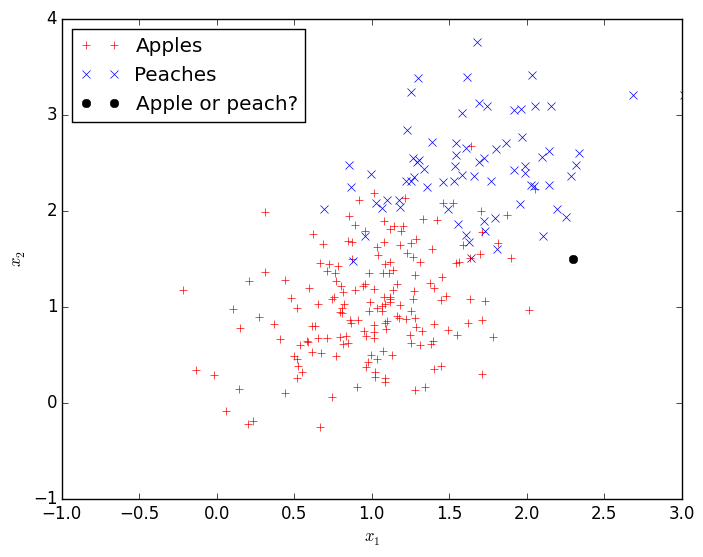

In [3]:
using Distributions, PyPlot
N = 250; p_apple = 0.7; Σ = [0.2 0.1; 0.1 0.3]
p_given_apple = MvNormal([1.0, 1.0], Σ) # p(X|y=apple)
p_given_peach = MvNormal([1.7, 2.5], Σ) # p(X|y=peach)
X = Matrix{Float64}(2,N); y = Vector{Bool}(N) # true corresponds to apple
for n=1:N
    y[n] = (rand() < p_apple) # Apple or peach?
    X[:,n] = y[n] ? rand(p_given_apple) : rand(p_given_peach) # Sample features
end
X_apples = X[:,find(y)]'; X_peaches = X[:,find(!y)]' # Sort features on class
x_test = [2.3; 1.5] # Features of 'new' data point

function plot_fruit_dataset()
    # Plot the data set and x_test
    plot(X_apples[:,1], X_apples[:,2], "r+")   # apples
    plot(X_peaches[:,1], X_peaches[:,2], "bx") # peaches
    plot(x_test[1], x_test[2], "ko")           # 'new' unlabelled data point
    legend(["Apples"; "Peaches"; "Apple or peach?"], loc=2)
    xlabel(L"x_1"); ylabel(L"x_2"); xlim([-1,3]); ylim([-1,4])
end
plot_fruit_dataset();

### Generative Classification Problem Statement

- Given is a data set  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$
  - inputs $x_n \in \mathbb{R}^D$ are called **features**.
  - outputs $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$; The **discrete** targets $\mathcal{C}_k$ are called **classes**.

- We will again use the 1-of-$K$ notation for the discrete classes. Define the binary **class selection variable**

$$
y_{nk} = \begin{cases} 1 & \text{if $y_n$ in class $\mathcal{C}_k$}\\
        0 & \text{otherwise} \end{cases}
$$

-  The plan for generative classification: build a model for the joint pdf $p(x,y)= p(x|y)p(y)$ and use Bayes to infer the posterior class probabilities 

$$
p(y|x) = \frac{p(x|y) p(y)}{\sum_{y} p(x|y) p(y)}
$$


###  1 - Model specification 

##### Likelihood

- Assume Gaussian **class-conditional distributions** with **constant covariance matrix** across the classes,
 $$
 p(x_n|\mathcal{C}_{k}) = \mathcal{N}(x_n|\mu_k,\Sigma)
 $$
with notational shorthand: $\mathcal{C}_{k} \triangleq (y_{nk}=1)$.

##### Prior

- We use a categorical distribution for the class labels $y_{nk}$: 
$$p(\mathcal{C}_{k}) = \pi_k$$

- This leads to
$$
 p(x_n,\mathcal{C}_{k}) =  \pi_k \cdot \mathcal{N}(x_n|\mu_k,\Sigma)
$$ 

- The log-likelihood for the full data set is then
$$\begin{align*}
\log\, &p(D|\theta) \stackrel{\text{IID}}{=} \sum_n \log p(x_n,\mathcal{C}_{1},\ldots,\mathcal{C}_{K} \,|\,\theta) \\
  &= \sum_n \log \prod_k p(x_n,\mathcal{C}_{k}|\theta)^{y_{nk}} \;\;\text{(use 1-of-K coding)} \\
  &=  \sum_{n,k} y_{nk} \log p(x_n,\mathcal{C}_{k}|\theta) \\
   &=  \sum_{n,k} y_{nk}  \log\mathcal{N}(x_n|\mu_k,\Sigma)  +  \sum_{n,k} y_{nk} \log \pi_k \\
   &=  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{Gaussian} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{multinomial} } 
\end{align*}$$
where we used $m_k \triangleq \sum_n y_{nk}$.

- As usual, the rest (inference for parameters and model prediction) through straight probability theory.



### 2 -  Parameter Inference for Classification

We'll do ML estimation of $\theta = \{ \pi_k, \mu_k, \Sigma \}$ from data $D$

-  Recall (from the previous slide) the log-likelihood
$$
\log\, p(D|\theta) =  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{Gaussian} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{multinomial} } 
$$

- Maximization of the LLH breaks down into
  -  **Gaussian density estimation** for parameters $\mu_k, \Sigma$, since the first term contains exactly the LLH for MVG density estimation (see lesson on Density Est., Eq.1) 
  - **Multinomial density estimation** for class priors $\pi_k$, since the second term holds exactly the LLH for multinomial density estimation (see lesson on Density Estimation, Eq.2). 
  
It follows (by similar computations) that

- ML for multinomial prior (we've done this before!)
\begin{align}   
\hat \pi_k = m_k/N \tag{class prior}
\end{align}

- Now group the data into separate classes and do MVG ML estimation for class-conditional parameters (we've done this as well).

$$\begin{align*}
 \hat \mu_k &= \frac{ \sum_n y_{nk} x_n} { \sum_n y_{nk} } = \frac{1}{m_k} \sum_n y_{nk} x_n \tag{class-cond. mean}\\
 \hat \Sigma  &= \frac{1}{N} \sum_{n,k} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T \tag{variance}\\
  &= \sum_k \hat \pi_k \cdot \underbrace{ \left( \frac{1}{m_k} \sum_{n} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T  \right) }_{ \text{class-cond. variance} } \\
  &= \sum_k \hat \pi_k \cdot \hat \Sigma_k
\end{align*}$$

- Note that $y_{nk}$ groups data from the same class.






###  3 - Application: Class prediction for new Data

-  Given a 'new' input $x_\bullet$, use Bayes rule to get posterior class probability
$$\begin{align*}
 p(\mathcal{C}_k|x_\bullet,\theta ) &\propto p(\mathcal{C}_k) \,p(x_\bullet|\mathcal{C}_k) \\
  &\propto \pi_k \exp \left\{ { - {\frac{1}{2}}(x_\bullet - \mu_k )^T \Sigma^{ - 1} (x_\bullet - \mu_k )} \right\}\\
  &\propto \exp \left\{ {\mu_k^T \Sigma^{ - 1} x_\bullet - {\frac{1}{2}}\mu_k^T \Sigma^{ - 1} \mu_k  + \log \pi_k } \right\}  \\
  &=  \exp\{\beta_k^T x + \gamma_k\}
\end{align*}$$
where 
$$\begin{align*}
\beta_k &= \Sigma^{-1} \mu_k \\
\gamma_k &= - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k  + \log \pi_k \,.
\end{align*}$$

- The class posterior $\frac{\exp(a_k)}{\sum_{k^\prime}\exp(a_{k^\prime})}$ is called a **softmax** function. 



###  Discrimination Boundaries

-  The class posterior $\log p(\mathcal{C}_k|x) \propto \beta_k^T x + \gamma_k$ is a linear function of the input features.

-  Thus, the contours of equal probability (**discriminant functions**) are lines (hyperplanes) in feature space"
$$
\log \frac{{p(\mathcal{C}_k|x,\theta )}}{{p(\mathcal{C}_j|x,\theta )}} = \beta_{kj}^T x + \gamma_{kj} = 0
$$
where we defined $\beta_{kj} \triangleq \beta_k - \beta_j$ and similarly for $\gamma_{kj}$.

-  (homework). What happens if we had not assumed class-independent variances $\Sigma_k=\Sigma$? Are the discrimination functions still linear? quadratic?

-  How to classify a new input $x_\bullet$? The Bayesian answer is a posterior distribution $ p(\mathcal{C}_k|x_\bullet)$. If you must choose, then the class with maximum posterior class probability
$$\begin{align*}
k^* &= \arg\max_k p(\mathcal{C}_k|x_\bullet) \\
  &= \arg\max_k \left( \beta _k^T x_\bullet + \gamma_k \right)
\end{align*}$$
is an appealing decision. 


#### CODE EXAMPLE

We'll apply the above results to solve the "apple or peach" example problem.

p(apple|x=x∙) = 0.5994380587800092


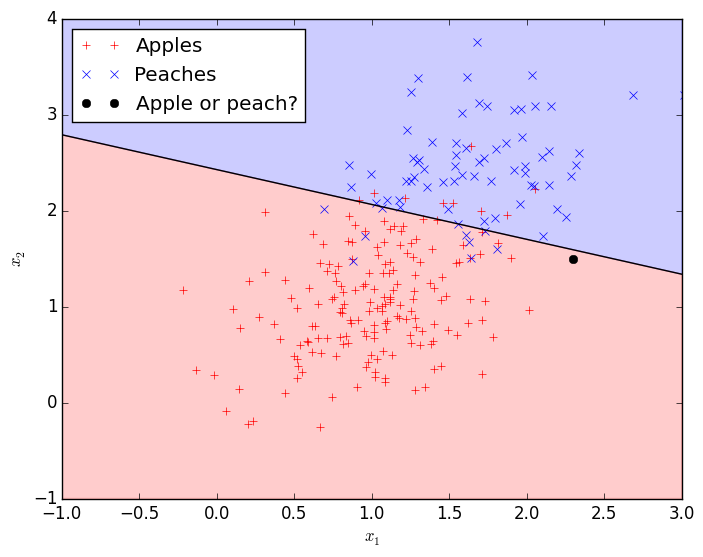

In [4]:
# Make sure you run the data-generating code cell first

# Multinomial (in this case binomial) density estimation
p_apple_est = sum(y.==true) / length(y)
π_hat = [p_apple_est; 1-p_apple_est]

# Estimate class-conditional multivariate Gaussian densities
d1 = fit_mle(FullNormal, X_apples')  # MLE density estimation d1 = N(μ₁, Σ₁)
d2 = fit_mle(FullNormal, X_peaches') # MLE density estimation d2 = N(μ₂, Σ₂)
Σ = π_hat[1]*cov(d1) + π_hat[2]*cov(d2) # Combine Σ₁ and Σ₂ into Σ
conditionals = [MvNormal(mean(d1), Σ); MvNormal(mean(d2), Σ)] # p(x|C)

# Calculate posterior class probability of x∙ (prediction)
function predict_class(k, X) # calculate p(Ck|X)
    norm = π_hat[1]*pdf(conditionals[1],X) + π_hat[2]*pdf(conditionals[2],X)
    return π_hat[k]*pdf(conditionals[k], X) ./ norm
end
println("p(apple|x=x∙) = $(predict_class(1,x_test))")

# Discrimination boundary of the posterior (p(apple|x;D) = p(peach|x;D) = 0.5)
β(k) = inv(Σ)*mean(conditionals[k])
γ(k) = -0.5 * mean(conditionals[k])' * inv(Σ) * mean(conditionals[k]) + log(π_hat[k])
function discriminant_x2(x1)
    # Solve discriminant equation for x2
    β12 = β(1) - β(2)
    γ12 = (γ(1) - γ(2))[1,1]
    return -1*(β12[1]*x1 + γ12) ./ β12[2]
end
plot_fruit_dataset() # Plot dataset
x1 = linspace(-1,3,10)
plot(x1, discriminant_x2(x1), "k-") # Plot discrimination boundary
fill_between(x1, -1, discriminant_x2(x1), color="r", alpha=0.2)
fill_between(x1, discriminant_x2(x1), 4, color="b", alpha=0.2);

#### END OF CODE EXAMPLE

###  Recap Generative Classification

- Model spec. $p(x,\mathcal{C}_k|\,\theta) = \pi_k \cdot \mathcal{N}(x|\mu_k,\Sigma)$

- If the class-conditional distributions are Gaussian with equal covariance matrices across classes ($\Sigma_k = \Sigma$), then
    the discriminant functions are hyperplanes in feature space.

- ML estimation for $\{\pi_k,\mu_k,\Sigma\}$ breaks down to simple density estimation for Gaussian and multinomial.

- Posterior class probability is a softmax function
$$ p(\mathcal{C}_k|x,\theta ) \propto \exp\{\beta_k^T x + \gamma_k\}$$
where $\beta _k= \Sigma^{-1} \mu_k$ and $\gamma_k=- \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k  + \log \pi_k$.


-----
_The cell below loads the style file_


In [5]:
open("../../styles/aipstyle.html") do f
    display("text/html", readall(f))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->